# Prédictions : courbes d'apprentissages selon différents modèles et différents paramètres

Afin d'y voir un peu plus clair dans la jungle des paramètres possibles 

 + feature engineering avec différentes échelles
 + différents tactiques d'imputation de données
 + etc
 
 on va tracer des courbes d'apprentissage, afin de sélectionner les meilleures options.

In [38]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source(file="experiments/learning_curve/learning_curve.R")
source(file="experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)
library(ggplot2)

library(randomForest)
library(e1071)

[1] "/home/sapristi/Documents/ML"


In [30]:
train.raw <- read.csv("datasets/titanic_na/train.csv")

remove.na <- function(df) {
    df$Fare[df$Fare == 0] <- NA
    narows <- is.na(df$Age) | (is.na(df$Fare))
    res <- df[!narows,]
    res$SurvivedF <- as.factor(res$Survived)
    return(res)
}

train.nona <- remove.na(train.raw)


## 1 Fonctions pour différents modèles

Fonction pour ploter plusieurs learning curves d'un coup

In [31]:
make_learning_curves <- function(model_funs, predict_funs, train, test, target, features, steps, limit=NULL, title = NULL) {
    plot <- NULL
    for (model in names(model_funs)) {
        model_fun <- model_funs[[model]]
        predict_fun <- predict_funs[[model]]
        plot <- learning_curve$plot(train, test, target, features, model_fun, predict_fun, steps, title = model, previous_plot = plot, limit = limit)
    }
    plot <- learning_curve$make_decor(plot, title, ymin=0.5)
    return(plot)
}

Paramètres à fournir

In [32]:
logreg.model_fun <- function(formula, train) {
  return(glm(as.formula(formula), data = train, family = binomial(link = "logit")))
}
logreg.predict_fun <- function(model, data) {
  plogis(predict(model, data))
}


svm.linear.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="linear", cost=50, coef0=1,
             type="C-classification"))
}


svm.logi.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="sigmoid",  cost=50, coef0=1,
             type="C-classification"))
}


svm.poly.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="polynomial", degree=3, cost=50, coef0=1,
             type="C-classification"))
}

rf.model_fun <- function(formula, train) {
  randomForest(as.formula(formula), 
               data = train, na.action = na.roughfix)
}


#model_funs <- list(logreg = logreg.model_fun, svm.linear = svm.linear.model_fun, svm.logi = svm.logi.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun)
#predict_funs <- list(logreg = logreg.predict_fun)

model_funs <- list(svm.linear = svm.linear.model_fun, svm.logi = svm.logi.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun)
predict_funs <- list()

# randomize input order
train.rand <- train.nona[sample(nrow(train.nona)),]

In [35]:
features <- c("Pclass", "Sex", "Age", "SibSp", "Parch", "Fare")
lcs.initial1 <- make_learning_curves(model_funs, predict_funs, train.rand, 0.1, "SurvivedF",  features, steps=50, title = "full features")

features <- c("Pclass", "Sex", "Age", "Fare")
lcs.initial2 <- make_learning_curves(model_funs, predict_funs, train.rand, 0.1, "SurvivedF",  features, steps=50, title = "less features")

Warning message:
“Removed 1 rows containing missing values (geom_path).”

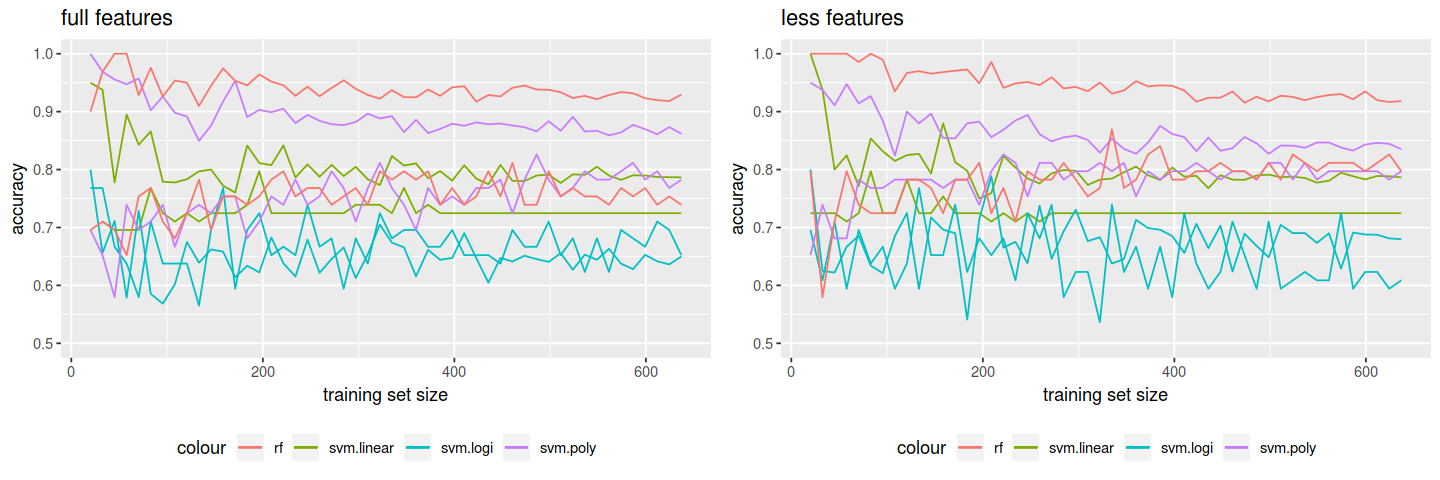

In [36]:
options(repr.plot.height= 4,repr.plot.width= 12)
grid.arrange(lcs.initial1, lcs.initial2, nrow = 1)

On a enlevé regression logistique, qui demande comme target `Survived` et non `SurvivedF`. Les résultats obtenus avec ce modèle étaient de toute façon peu probants.


Les résultats sont ici un peu meilleurs quand on enlève des features : moins de biais et meilleure précision.

## 2 Courbes avec les forged features

In [39]:
test.raw <- read.csv("datasets/titanic_na/test.csv")

train <- fe$forge_features_add(train.nona, more_tickets = test.raw$Ticket)

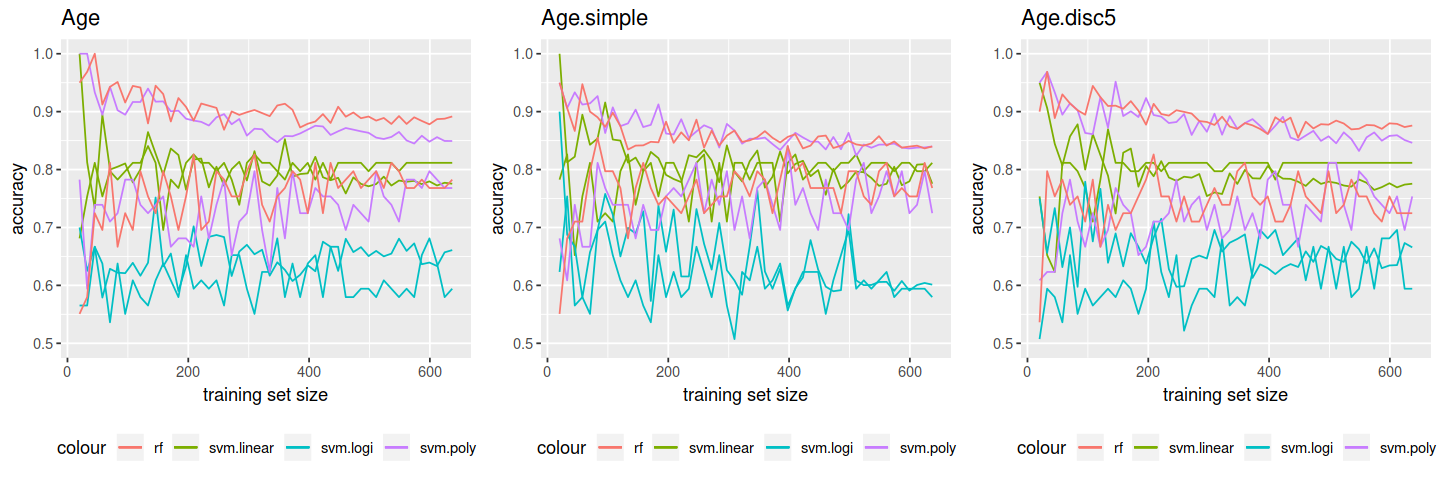

In [40]:
features <- c("Pclass", "Sex", "Age", "SibSp", "Parch")
lcs.ff.age <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Age")

features <- c("Pclass", "Sex", "Age.simple", "SibSp", "Parch")
lcs.ff.age.disc5 <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Age.simple")

features <- c("Pclass", "Sex", "Age.disc5", "SibSp", "Parch")
lcs.ff.age.simple <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Age.disc5")

grid.arrange(lcs.ff.age, lcs.ff.age.disc5, lcs.ff.age.simple , nrow = 1)

Age.simple a l'air de réduire le biais, et amèliore la précision de svm.poly et svm.linear.

Age.disc5 réduit légèrement le biais, mais réduit la précision de rf et svm poly.

Warning message:
“Removed 1 rows containing missing values (geom_path).”

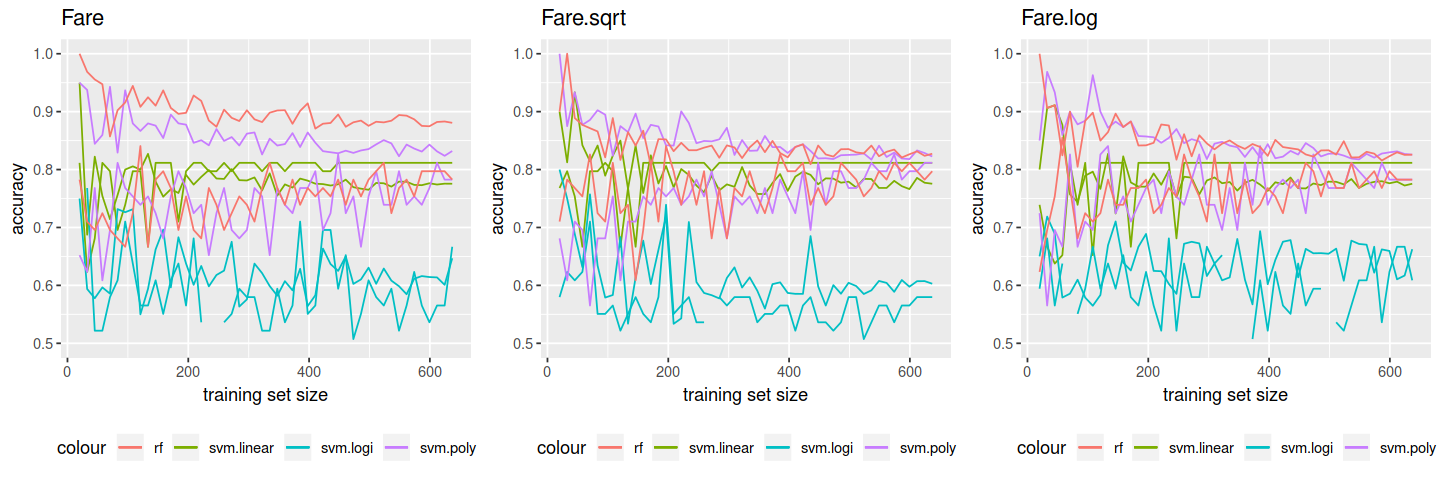

In [42]:
features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare")
lcs.ff.fare <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Fare")

features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare.sqrt")
lcs.ff.fare.sqrt <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Fare.sqrt")

features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare.log")
lcs.ff.fare.log <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Fare.log")

grid.arrange(lcs.ff.fare, lcs.ff.fare.sqrt, lcs.ff.fare.log, nrow = 1)

Not much difference between Fare.sqrt and Fare.log. Fare.sqrt seems a bit more regular, but Fare.log has a little better precision.

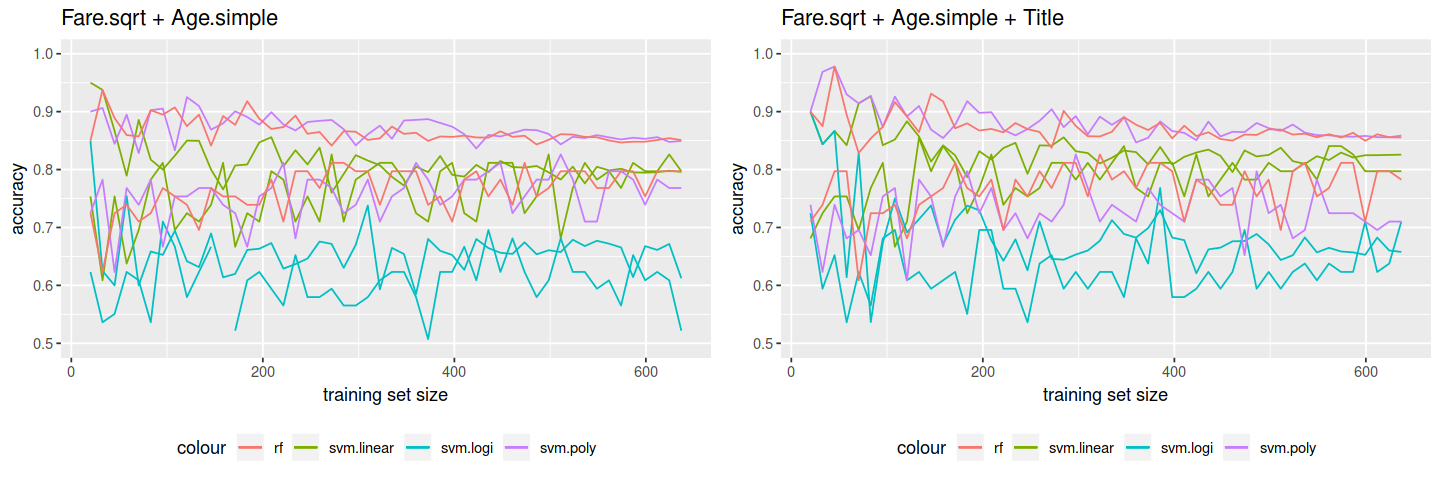

In [43]:
features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare.log", "Age.simple")
lcs.ff.age_s.fare_sqrt <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Fare.sqrt + Age.simple")

features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare.log", "Age.simple", "Title")
lcs.ff.title <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Fare.sqrt + Age.simple + Title")

grid.arrange(lcs.ff.age_s.fare_sqrt, lcs.ff.title, nrow = 1)

Title doesn't seem very helpfull : more bias, and maybe less accuracy.

In [44]:
features <- c("Pclass", "Sex", "SibSp", "Parch", "Fare.log", "Age.simple")
lcs.ff.full <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "Full - title")

features <- c("Pclass", "Sex", "Fare.log", "Age.simple")
lcs.ff.less <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "less + Sex")

features <- c("Pclass", "Title", "Fare.log", "Age.simple")
lcs.ff.lesstitle <- make_learning_curves(model_funs, predict_funs, train, 0.1, "SurvivedF",  features, steps=50, title = "less + Title")

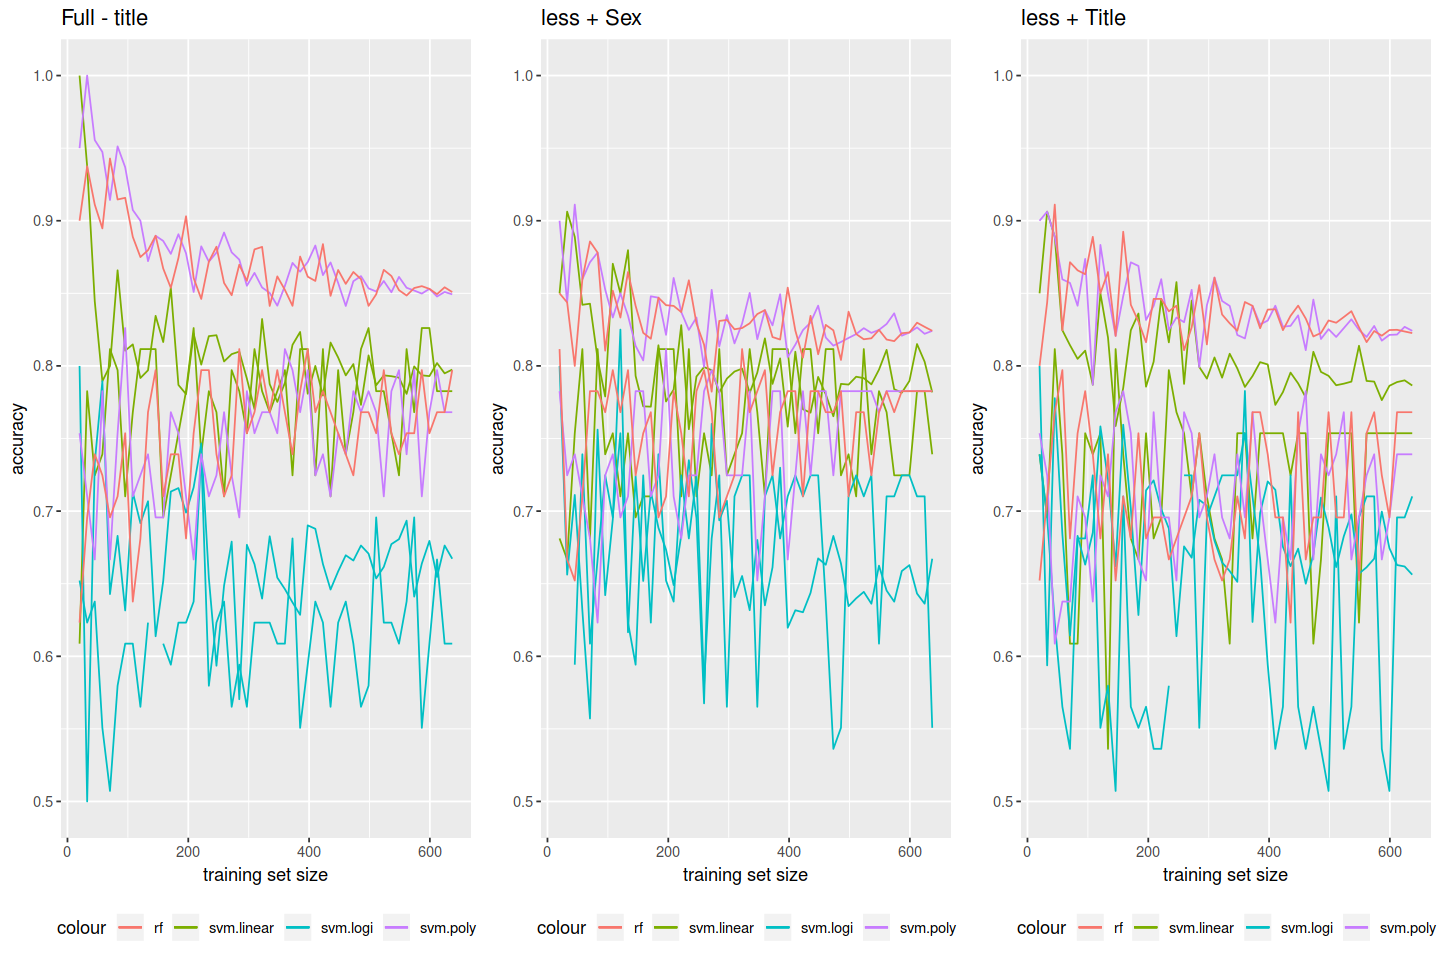

In [46]:
options(repr.plot.height= 8,repr.plot.width= 12)
grid.arrange(lcs.ff.full, lcs.ff.less, lcs.ff.lesstitle, nrow = 1)

Removing variables improves randomForest, but worsens svm.poly and svm.linear. Title really show to be useless.

## 3 Adding imputed data